# Classification Models

Train classification models to identify high-impact papers (top 25%):
1. Load features and targets
2. Train baseline models
3. 5-fold cross-validation
4. Evaluate on temporal test set
5. Save best models

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
from pathlib import Path
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
%matplotlib inline

## 1. Load Data

In [2]:
feature_dir = Path('../data/features')

X_train = pd.read_pickle(feature_dir / 'X_train_temporal.pkl')
X_test = pd.read_pickle(feature_dir / 'X_test_temporal.pkl')
y_train = pd.read_pickle(feature_dir / 'y_train_cls_temporal.pkl')
y_test = pd.read_pickle(feature_dir / 'y_test_cls_temporal.pkl')

print(f"Train: {X_train.shape}, High-impact: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"Test: {X_test.shape}, High-impact: {y_test.sum()} ({y_test.mean()*100:.1f}%)")

Train: (2545, 5019), High-impact: 941 (37.0%)
Test: (3573, 5019), High-impact: 1068 (29.9%)


## 2. Define Models

In [3]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, class_weight='balanced', n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, scale_pos_weight=2.5, n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, class_weight='balanced', n_jobs=-1, verbose=-1)
}

print("Models defined:")
for name in models.keys():
    print(f"  - {name}")

Models defined:
  - Logistic Regression
  - Random Forest
  - XGBoost
  - LightGBM


## 3. Train and Evaluate with Cross-Validation

In [4]:
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    
    cv_results[name] = {
        'accuracy': scores['test_accuracy'].mean(),
        'precision': scores['test_precision'].mean(),
        'recall': scores['test_recall'].mean(),
        'f1': scores['test_f1'].mean(),
        'roc_auc': scores['test_roc_auc'].mean()
    }
    
    print(f"  Accuracy: {cv_results[name]['accuracy']:.4f}")
    print(f"  Precision: {cv_results[name]['precision']:.4f}")
    print(f"  Recall: {cv_results[name]['recall']:.4f}")
    print(f"  F1: {cv_results[name]['f1']:.4f}")
    print(f"  ROC-AUC: {cv_results[name]['roc_auc']:.4f}")

cv_df = pd.DataFrame(cv_results).T
print("\nCross-validation results:")
print(cv_df)


Training Logistic Regression...
  Accuracy: 0.7147
  Precision: 0.5972
  Recall: 0.7024
  F1: 0.6453
  ROC-AUC: 0.7902

Training Random Forest...
  Accuracy: 0.7238
  Precision: 0.6238
  Recall: 0.6397
  F1: 0.6314
  ROC-AUC: 0.7821

Training XGBoost...
  Accuracy: 0.6849
  Precision: 0.5560
  Recall: 0.7333
  F1: 0.6322
  ROC-AUC: 0.7611

Training LightGBM...
  Accuracy: 0.6994
  Precision: 0.5820
  Recall: 0.6642
  F1: 0.6201
  ROC-AUC: 0.7662

Cross-validation results:
                     accuracy  precision    recall        f1   roc_auc
Logistic Regression  0.714735   0.597196  0.702443  0.645332  0.790193
Random Forest        0.723772   0.623843  0.639739  0.631426  0.782072
XGBoost              0.684872   0.556018  0.733328  0.632247  0.761103
LightGBM             0.699411   0.582022  0.664162  0.620144  0.766154


## 4. Train on Full Training Set and Evaluate on Test Set

In [5]:
test_results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name} on full training set...")
    
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    test_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    print(f"Test Set Performance:")
    print(f"  Accuracy: {test_results[name]['accuracy']:.4f}")
    print(f"  Precision: {test_results[name]['precision']:.4f}")
    print(f"  Recall: {test_results[name]['recall']:.4f}")
    print(f"  F1: {test_results[name]['f1']:.4f}")
    print(f"  ROC-AUC: {test_results[name]['roc_auc']:.4f}")

test_df = pd.DataFrame(test_results).T
print("\nTest set results:")
print(test_df)


Training Logistic Regression on full training set...


c:\Users\Mario.Chartouni\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Set Performance:
  Accuracy: 0.7005
  Precision: 0.4994
  Recall: 0.7584
  F1: 0.6022
  ROC-AUC: 0.7901

Training Random Forest on full training set...
Test Set Performance:
  Accuracy: 0.7162
  Precision: 0.5195
  Recall: 0.6723
  F1: 0.5861
  ROC-AUC: 0.7766

Training XGBoost on full training set...
Test Set Performance:
  Accuracy: 0.6580
  Precision: 0.4582
  Recall: 0.7893
  F1: 0.5798
  ROC-AUC: 0.7695

Training LightGBM on full training set...
Test Set Performance:
  Accuracy: 0.6961
  Precision: 0.4942
  Recall: 0.7144
  F1: 0.5842
  ROC-AUC: 0.7703

Test set results:
                     accuracy  precision    recall        f1   roc_auc
Logistic Regression  0.700532   0.499383  0.758427  0.602230  0.790098
Random Forest        0.716205   0.519537  0.672285  0.586122  0.776611
XGBoost              0.657990   0.458152  0.789326  0.579780  0.769524
LightGBM             0.696054   0.494171  0.714419  0.584227  0.770251


## 5. Compare Models

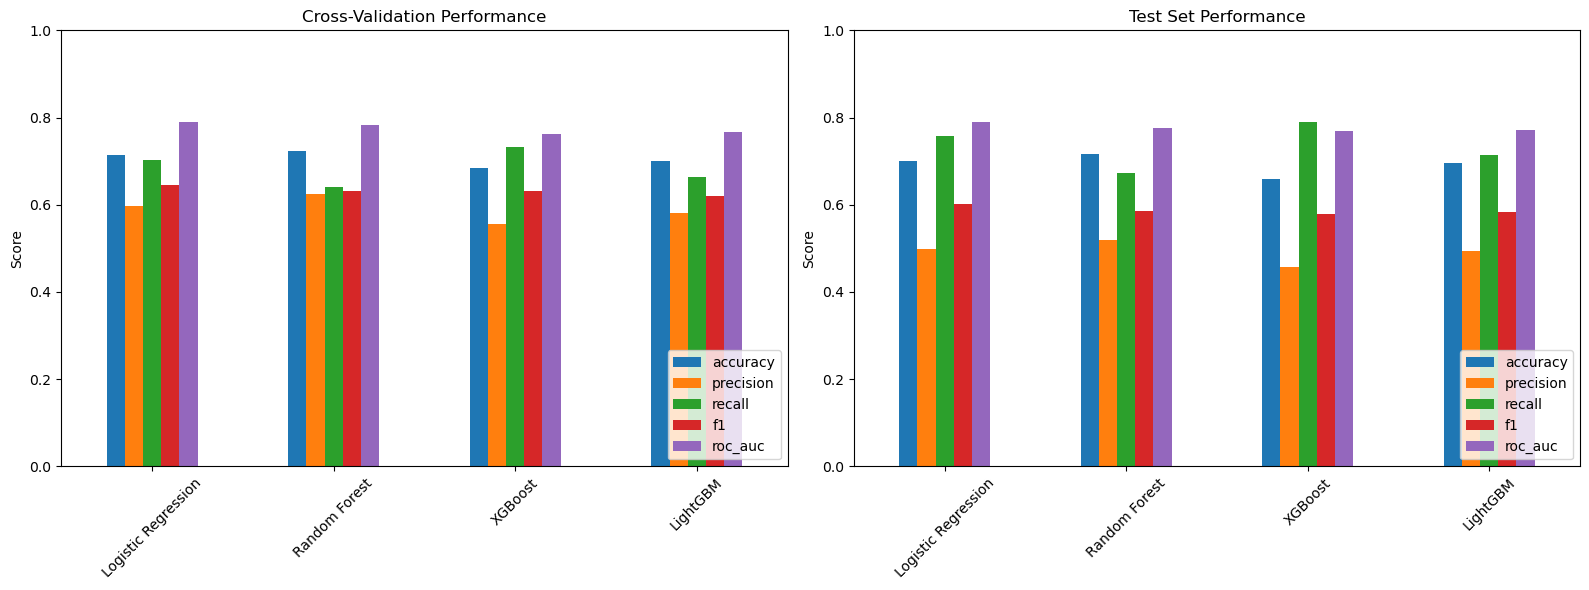

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cv_df.plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Cross-Validation Performance')
axes[0].set_ylabel('Score')
axes[0].set_ylim([0, 1])
axes[0].legend(loc='lower right')

test_df.plot(kind='bar', ax=axes[1], rot=45)
axes[1].set_title('Test Set Performance')
axes[1].set_ylabel('Score')
axes[1].set_ylim([0, 1])
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

## 6. Confusion Matrices

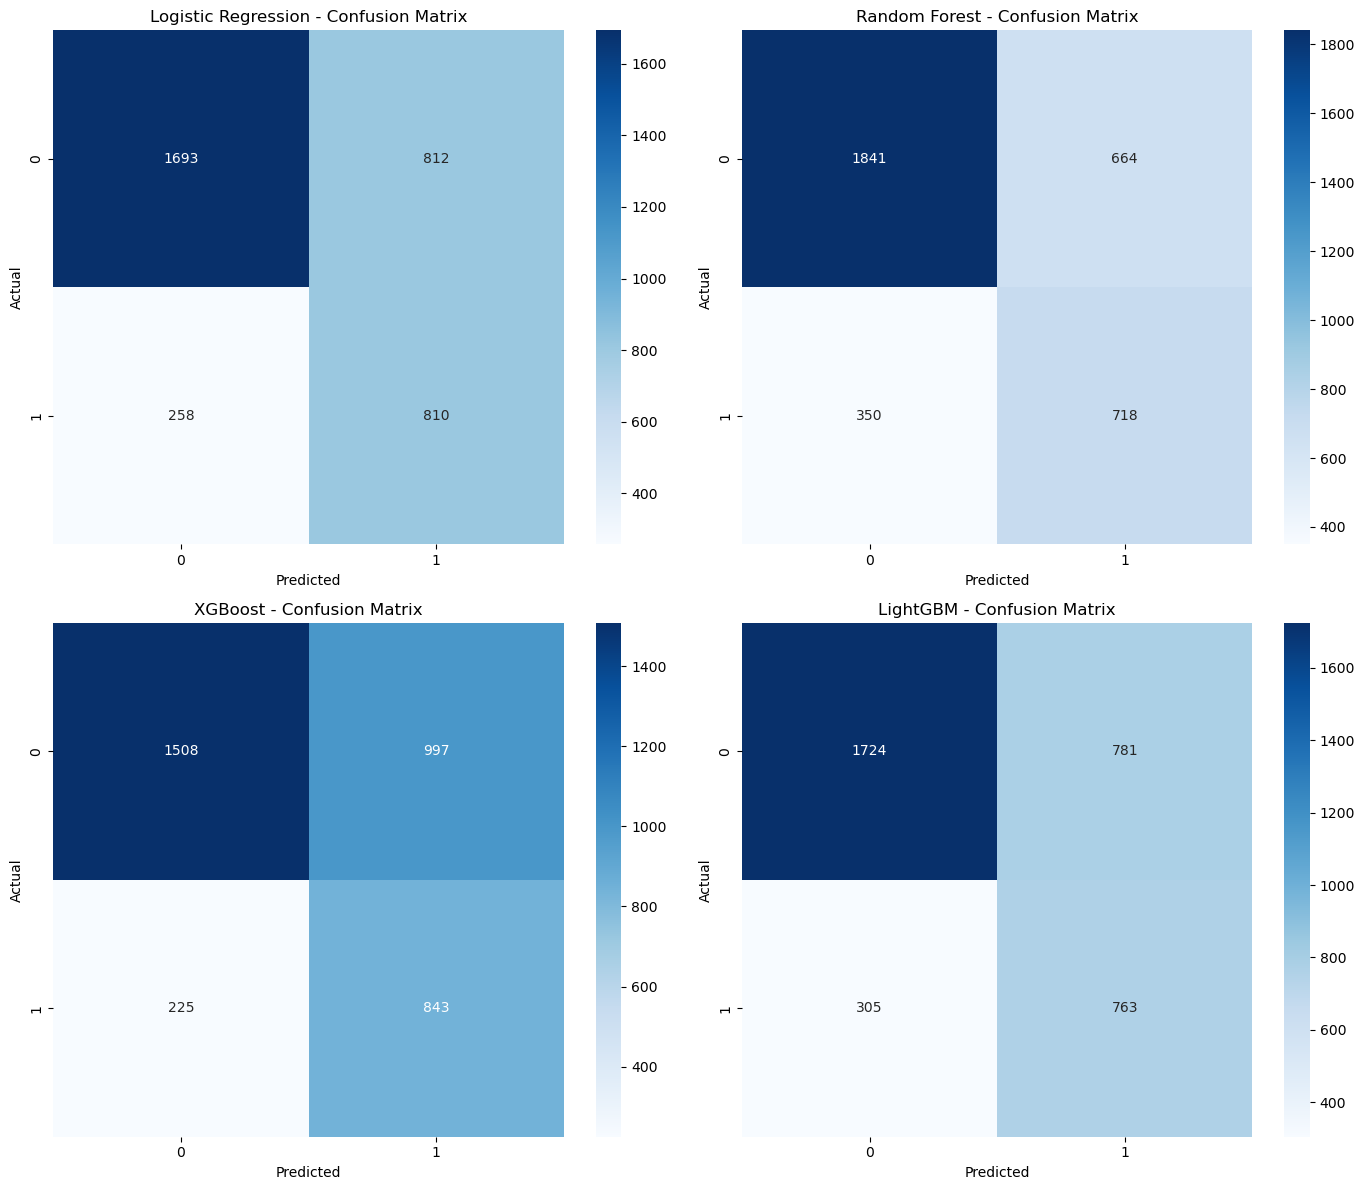

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (name, model) in enumerate(trained_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name} - Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 7. Save Models

In [8]:
model_dir = Path('../models/classification')
model_dir.mkdir(parents=True, exist_ok=True)

for name, model in trained_models.items():
    filename = name.lower().replace(' ', '_') + '.pkl'
    with open(model_dir / filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved: {filename}")

results_df = pd.DataFrame({
    'CV_F1': cv_df['f1'],
    'CV_ROC_AUC': cv_df['roc_auc'],
    'Test_F1': test_df['f1'],
    'Test_ROC_AUC': test_df['roc_auc']
})
results_df.to_csv('../reports/metrics/classification_results.csv')
print(f"\nResults saved to reports/metrics/classification_results.csv")

Saved: logistic_regression.pkl
Saved: random_forest.pkl
Saved: xgboost.pkl
Saved: lightgbm.pkl

Results saved to reports/metrics/classification_results.csv


## Summary

In [9]:
print("=" * 60)
print("CLASSIFICATION MODELS SUMMARY")
print("=" * 60)
print(f"\nBest CV F1: {cv_df['f1'].idxmax()} ({cv_df['f1'].max():.4f})")
print(f"Best CV ROC-AUC: {cv_df['roc_auc'].idxmax()} ({cv_df['roc_auc'].max():.4f})")
print(f"\nBest Test F1: {test_df['f1'].idxmax()} ({test_df['f1'].max():.4f})")
print(f"Best Test ROC-AUC: {test_df['roc_auc'].idxmax()} ({test_df['roc_auc'].max():.4f})")

CLASSIFICATION MODELS SUMMARY

Best CV F1: Logistic Regression (0.6453)
Best CV ROC-AUC: Logistic Regression (0.7902)

Best Test F1: Logistic Regression (0.6022)
Best Test ROC-AUC: Logistic Regression (0.7901)
